# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.drop(['RegionID','SizeRank'],axis=1,inplace=True)

In [4]:
df.shape

(14723, 270)

# Step 2: Data Preprocessing

In [5]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')
   

In [6]:
df.isna().sum().sum()

157934

# Step 3: EDA and Visualization

In [7]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Step 4: Reshape from Wide to Long Format

In [8]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    #melted = melted.dropna(subset=['value'])
    return melted



In [9]:
long_df=melt_data(df)
long_df.head()

,RegionName,City,State,Metro,CountyName,time,value
0,60657,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,77494,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,60614,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,79936,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [10]:
sorted_long_df = long_df.sort_values(['RegionName','time'])

In [11]:
sorted_long_df

,RegionName,City,State,Metro,CountyName,time,value
5850,1001,Agawam,MA,Springfield,Hampden,1996-04-01,113100.0
20573,1001,Agawam,MA,Springfield,Hampden,1996-05-01,112800.0
35296,1001,Agawam,MA,Springfield,Hampden,1996-06-01,112600.0
50019,1001,Agawam,MA,Springfield,Hampden,1996-07-01,112300.0
64742,1001,Agawam,MA,Springfield,Hampden,1996-08-01,112100.0
...,...,...,...,...,...,...,...
3835273,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,2017-12-01,291900.0
3849996,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,2018-01-01,294200.0
3864719,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,2018-02-01,297500.0
3879442,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,2018-03-01,302100.0


In [12]:
sorted_long_df.RegionName.value_counts()

28658    265
35490    265
29372    265
19131    265
23225    265
        ... 
75035    265
77082    265
91411    265
93458    265
24588    265
Name: RegionName, Length: 14723, dtype: int64

In [13]:
sorted_long_df.value.isna().sum()

156891

In [14]:
df_1001 = sorted_long_df[:265]

In [15]:
df_1001.head()

,RegionName,City,State,Metro,CountyName,time,value
5850,1001,Agawam,MA,Springfield,Hampden,1996-04-01,113100.0
20573,1001,Agawam,MA,Springfield,Hampden,1996-05-01,112800.0
35296,1001,Agawam,MA,Springfield,Hampden,1996-06-01,112600.0
50019,1001,Agawam,MA,Springfield,Hampden,1996-07-01,112300.0
64742,1001,Agawam,MA,Springfield,Hampden,1996-08-01,112100.0


In [16]:
df_1001.set_index('time',inplace=True)

In [17]:
df_1001.head()

,RegionName,City,State,Metro,CountyName,value
time,,,,,,
1996-04-01,1001,Agawam,MA,Springfield,Hampden,113100.0
1996-05-01,1001,Agawam,MA,Springfield,Hampden,112800.0
1996-06-01,1001,Agawam,MA,Springfield,Hampden,112600.0
1996-07-01,1001,Agawam,MA,Springfield,Hampden,112300.0
1996-08-01,1001,Agawam,MA,Springfield,Hampden,112100.0


In [18]:
df_1001.loc['1996-04-01','RegionName']

1001

In [19]:
df_1001.isna().sum()

RegionName    0
City          0
State         0
Metro         0
CountyName    0
value         0
dtype: int64

In [20]:
df_1001_key = df_1001.drop(['RegionName','City','State','Metro','CountyName'],axis=1)
df_1001_key.head()

,value
time,
1996-04-01,113100.0
1996-05-01,112800.0
1996-06-01,112600.0
1996-07-01,112300.0
1996-08-01,112100.0


In [21]:
# roll_mean = df_1001_key.rolling(window=24, center=False).mean()
# roll_std = df_1001_key.rolling(window=24, center=False).std()

# fig = plt.figure(figsize=(12,7))
# plt.plot(df_1001_key, color='blue', label='Original')
# plt.plot(roll_mean, color='red', label='Rolling Mean')
# plt.plot(roll_std, color='black', label = 'Rolling Std')
# plt.legend(loc='best')
# plt.title('Rolling Mean & Standard Deviation')
# plt.show(block=False)

In [22]:
# dftest = adfuller(df_1001_key['value'])
# dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
# print ('Results of Dickey-Fuller test: \n')

# print(dfoutput)

In [23]:
# roll_mean = df_1001_key['value'].rolling(window=4).mean()
# data_minus_roll_mean = df_1001_key['value'] - roll_mean
# data_minus_roll_mean.head(15)

In [24]:
# fig = plt.figure(figsize=(11,7))
# plt.plot(data_minus_roll_mean, color='blue',label='Sales - rolling mean')
# plt.legend(loc='best')
# plt.title('Sales while the rolling mean is subtracted')
# plt.show(block=False)

In [25]:
# df_1001_key_diff = df_1001_key['value'].diff(periods=1).dropna()
# df_1001_key_diff.head(10)

In [26]:
# fig = plt.figure(figsize=(11,7))
# plt.plot(df_1001_key_diff, color='blue',label='Differenced Price')
# plt.legend(loc='best')
# plt.title('Differenced sales series')
# plt.show(block=False)

In [27]:
# # Import and apply seasonal_decompose()
# from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition = seasonal_decompose(np.log(df_1001_key['value']))

# # Gather the trend, seasonality, and residuals 
# trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid

# # Plot gathered statistics
# plt.figure(figsize=(12,8))
# plt.subplot(411)
# plt.plot(np.log(df_1001_key['value']), label='Original', color='blue')
# plt.legend(loc='best')
# plt.subplot(412)
# plt.plot(trend, label='Trend', color='blue')
# plt.legend(loc='best')
# plt.subplot(413)
# plt.plot(seasonal,label='Seasonality', color='blue')
# plt.legend(loc='best')
# plt.subplot(414)
# plt.plot(residual, label='Residuals', color='blue')
# plt.legend(loc='best')
# plt.tight_layout()

In [28]:
# def stationarity_check(TS):
    
#     # Import adfuller
#     from statsmodels.tsa.stattools import adfuller
    
#     # Calculate rolling statistics
#     roll_mean = TS.rolling(window=12, center=False).mean()
#     roll_std = TS.rolling(window=12, center=False).std()
    
#     # Perform the Dickey Fuller test
#     dftest = adfuller(TS) 
    
#     # Plot rolling statistics:
#     fig = plt.figure(figsize=(12,6))
#     orig = plt.plot(TS, color='blue',label='Original')
#     mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
#     std = plt.plot(roll_std, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
    
#     # Print Dickey-Fuller test results
#     print('Results of Dickey-Fuller Test: \n')

#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
#                                              '#Lags Used', 'Number of Observations Used'])
#     for key, value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print(dfoutput)
    
#     return None

In [29]:
# # Drop missing values from residuals 
# ts_log_decompose = residual
# ts_log_decompose.dropna(inplace=True)

# # Check stationarity
# stationarity_check(ts_log_decompose)

This log_decompose series is stationary! We can model it 

In [30]:
# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.graphics.tsaplots import plot_pacf

# fig, ax = plt.subplots(figsize=(8,3))
# plot_acf(ts_log_decompose,ax=ax, lags=8);

# fig, ax = plt.subplots(figsize=(8,3))
# plot_pacf(ts_log_decompose,ax=ax, lags=8);

# Step 5: ARIMA Modeling

In [36]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [37]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_1001_key,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
        except:
            continue
#We have run every possible permutation of the parameters of our model

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           3533.42
Name: 59, dtype: object

adding another level of permutations took it from 11 seconds to 28 minutes! and the AIC only went down to 3246. This level is fine for our purposes

In [38]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_1001_key, 
                                        order=ans_df.loc[ans_df['aic'].idxmin()]['pdq'], 
                                        seasonal_order=ans_df.loc[ans_df['aic'].idxmin()]['pdqs'], 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8478      0.029     29.342      0.000       0.791       0.904
ma.L1          0.6212      0.032     19.405      0.000       0.558       0.684
ma.S.L12      -0.7487      0.040    -18.645      0.000      -0.827      -0.670
sigma2      1.211e+05   7723.781     15.685      0.000    1.06e+05    1.36e+05


In [ ]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
pred = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df_1001_key['1997':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

In [45]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int(alpha = .2)

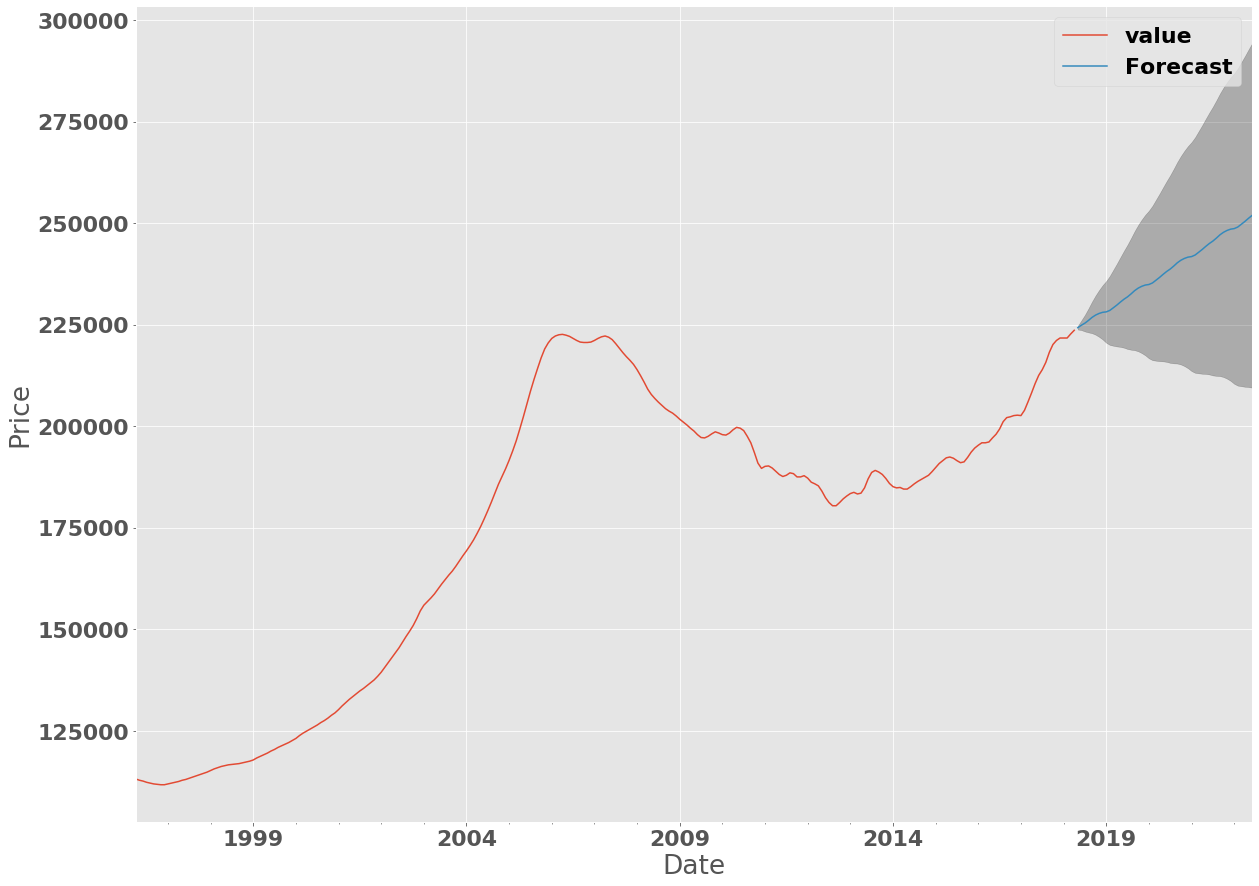

223600.0


In [49]:
# Plot future predictions with confidence intervals
ax = df_1001_key.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()
print(df_1001_key['value'][-1])

In [ ]:
# prediction.predicted_mean[-1]
# #this is going to be your definition of best 

In [ ]:

df.isna().sum().value

In [ ]:
record = {}

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for x in range(0,25): #note, this is limited again to 25 neighbourhoods, to save us computation time.
    df = sorted_long_df[x*265:(x+1)*265]
    df.set_index('time',inplace=True)
    region = df.loc['1997-04-01','RegionName']
    df = df.drop(['RegionName','City','State','Metro','CountyName'],axis=1)
    
    if (df.isna().sum().value)>0:
        df.bfill()
        print('There were missing values in {}!'.format(region))

    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue
    #We have run every possible permutation of the parameters of our model
    
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]
    #We store all the results, and find the set of parameters which gives us the lowest AIC, ie the most accurate model

    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                            order=ans_df.loc[ans_df['aic'].idxmin()]['pdq'], 
                                            seasonal_order=ans_df.loc[ans_df['aic'].idxmin()]['pdqs'], 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)
                                            #should i be enforcing these parameters? consider 

    output = ARIMA_MODEL.fit()
    #We then run this model again with these best parameters, allowing us to make the prediction 

    prediction = output.get_forecast(steps=50)
    #we predict the values for 50 months ahead of our last value
    
    record.update({region : (prediction.predicted_mean[-1]/df['value'][-1] - 1) * 100})
    #we record the final value in the 50th month, as a percentage increase from the last value we were given
    
    sorted_record = sorted(record.items(), key=lambda x: x[1], reverse=True)
    #we sort the values in order of highest increase
    
    print(sorted_record[:5])
    #we print out the best 5 neighbourhoods!


# Step 6: Interpreting Results